Original Opensees Example Link: https://opensees.berkeley.edu/wiki/index.php/OpenSees_Example_4._Portal_Frame

<img src="https://opensees.berkeley.edu/wiki/images/e/e0/Example4_figure1.GIF" align="left"></img>
<img src="https://opensees.berkeley.edu/wiki/images/5/59/Example1b_Push.GIF" align="right"></img>

In [3]:
import openseespy.opensees as ops
import opsvis as ovs
import numpy as np
import matplotlib.pyplot as plt
import math

## Units Conversion

In [10]:
#length conversion
m = 1.0
cm = 100*m # centimeter, needed for displacement input in MultipleSupport excitation
inch = m/39.37
ft = 12.*inch 

#area conversion
sqinch = inch**2
inch4 = inch**4

#ksi to pa
pa = 1.0
kpa = 1000*pa
ksi = 6.89*1000*kpa  #ksi = kip / sqinch
psi = ksi/1000.


#kip to kN
N = 1.0
kN = 1000 * N
kip = 4.45 * kN

# pound to kg
kg = 1 
pound = 0.453592 * kg
lbf = psi*inch**2  #pounds force
pcf = lbf/math.pow(ft, 3) #pounds per cubic foot
psf = lbf/math.pow(ft, 2) #pounds per square foot


# acceleration due to gravity
g = 9.81 #m/s^2

## Model Varibles for Elastic Element Section

In [28]:
#refrences taken from elastic model in original example 
sectionType = 'elastic'  #this analysis uses elastic section of beam and column

#Structure Geometry
LCol = 36.*ft		# column length
LBeam = 42.*ft		# beam length
Weight = 4000.*kip		# superstructure weight #total imposed load on the beam in kN or Kip


#section general geometry
HCol = 5.*ft #depth of column
BCol = 4.*ft #width of column
HBeam = 8.*ft #depth of beam
BBeam = 5.*ft #width of beam

# calculated parameters
PCol = Weight/2 #nodal dead weight per column
Mass = PCol/g #nodal mass
MCol = 1./12.* (Weight/LBeam) *math.pow(LBeam,2)	# beam-end moment due to distributed load.        #wl^2/12


#calculated geometry parameters
ACol = BCol * HCol
ABeam = BBeam * HBeam
IzCol = 1./12. * BCol * math.pow(HCol, 3)
IzBeam = 1./12. * BBeam * math.pow(HBeam, 3)

## Model Functions

In [25]:
def getModel():
    ops.wipe()
    ops.model("BasicBuilder", '-ndm', 2, '-ndf', 3)

    #nodes definition
    xcor = [0, LBeam]
    ycor = [0, LCol]
    for j,y in enumerate(ycor):
        for i,x in enumerate(xcor):
            ops.node(j*len(xcor)+i + 1, *[x,y])
    
    #fixity definition
    ops.fixY(0, *[1,1,1]) #fix all nodes with ycoordinate = 0 (so fixing both node 1 and 2: base nodes)

    # nodal masses:
    ops.mass(3, *[Mass, 0., 0.])	# node#, Mx My Mz, Mass=Weight/g, neglect rotational inertia at nodes
    ops.mass(4, *[Mass, 0., 0.])
    

In [27]:
def getSections():
    #geometric transformation define
    #performs a linear geometric transformation of beam stiffness and resisting force from the basic system to the global-coordinate system
    #it is better practice to keep separate transf tags for beams and columns
    colTransfTag = 1
    beamTransfTag = 2
    colTransfType = 'Linear'  #making this variable to help easy change of linear to pdelta, as only column have pdelta effects
    ops.geomTransf(colTransfType, colTransfTag)
    ops.geomTransf('Linear', beamTransfTag)
    

    #material properties
    fc = -4. * ksi # CONCRETE Compressive Strength (+Tension, -Compression)
    Ec = 57 * ksi * math.sqrt(-fc/psi) # Concrete Elastic Modulus
    
    #element define
    #element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, Iz, transfTag, <'-mass', mass>, <'-cMass'>, <'-release', releaseCode>)
    ops.element('elasticBeamColumn', 1, *[1,3], ACol, Ec, IzCol, colTransfTag) #col
    ops.element('elasticBeamColumn', 2, *[2,4], ACol, Ec, IzCol, colTransfTag)#col
    ops.element('elasticBeamColumn', 3, *[3,4], ABeam, Ec, IzBeam, beamTransfTag) #beam

## Recorder Functions

In [35]:
def getRecorders(SectionType, AnalyisName):
    ops.recorder("Node", '-file', f"Outputs/{SectionType}/{AnalyisName}_DispFree.txt", 
                 '-time', '-closeOnWrite', '-node', *[3,4],'-dof', *[1,2,3], 'disp')
    ops.recorder("Node", '-file', f"Outputs/{SectionType}/{AnalyisName}_DispSupport.txt", 
                 '-time', '-closeOnWrite', '-node', *[1,2],'-dof', *[1,2,3], 'disp')
    ops.recorder("Node", '-file', f"Outputs/{SectionType}/{AnalyisName}_ReactionsSupport.txt", 
                 '-time', '-closeOnWrite', '-node', *[1,2],'-dof', *[1,2,3], 'reaction')

    #drift recorder: but throws error in openseespy
    #ops.recorder("drift", '-file', f"Outputs/{SectionType}/{AnalyisName}_Drift.txt", '-time', '-closeOnWrite', '-inode', *[1,2],'-jnode', *[3,4], '-dof', 1, '-perpDirn', 2)
    
    #recorder Element -file Data/FCol.out -time -ele 1 force
    ops.recorder('Element', '-file', f'Outputs/{SectionType}/{AnalyisName}_ForcesColumn.txt', 
                 '-time', '-closeOnWrite', '-ele', *[1,2], 'globalForce')
    ops.recorder('Element', '-file', f'Outputs/{SectionType}/{AnalyisName}_ForcesBeam.txt', 
                 '-time', '-closeOnWrite', '-ele', 3, 'globalForce')				# Column section forces, axial and moment, node i


In [44]:
## Analysis Definitions
def runGravityAnalysis():
    udlBeam = Weight/LBeam
    #gravity loads
    ops.timeSeries('Linear', 1)
    ops.pattern('Plain', 1, 1) #patterntype #patterntag #timeseries tag
    ops.eleLoad('-ele', 3, '-type', '-beamUniform', -1* udlBeam)


    #setting gravity analysis parameters and functions
    ops.constraints('Plain')
    ops.numberer('Plain')
    ops.system('BandGeneral')
    
    tol = 1e-8
    numSteps = 6
    ops.test('NormDispIncr', tol, numSteps) #test NormDispIncr $tol $iter <$pFlag> <$nType>
    ops.algorithm('Newton')

    NStepGravity = 10
    DGravity = 1.0 / NStepGravity
    ops.integrator('LoadControl', DGravity)
    ops.analysis('Static')

    ops.record() #to force recorder to record initial state of the model regarding gravity loads
    ops.analyze(NStepGravity)

In [48]:
getModel()
getSections()
getRecorders('elastic', 'Gravity')
runGravityAnalysis()

<Axes: >

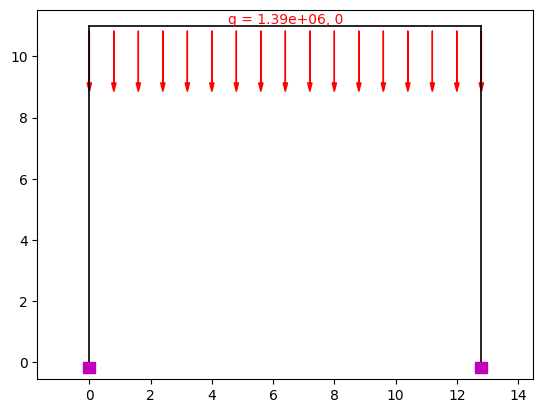

In [49]:
ovs.plot_loads_2d()

In [50]:
Weight / LBeam / 2

695224.2063492063